In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.fft import fft2, fftshift
import tqdm
from matplotlib.colors import LogNorm
import tools
import importlib
from IPython.display import HTML

In [79]:
importlib.reload(tools)

<module 'tools' from '/Users/tillmoritz/Desktop/Studies/Master_Studies/Oceanic_proc_obs/Git/ocean_pro/tools.py'>

## Load the data using the videoloader

In [80]:
#video_path = "/Users/clemensrohling/Desktop/Uni/Ocean and Climate Physics/Semester 3/Ocean/run_29.11.-35.9_36.4.avi"
#video_path_2 = "/Users/tillmoritz/Desktop/Studies/Master_Studies/Oceanic_proc_obs/13.12.-1.75-0.96.avi"
par2 = {'x_up':300,'x_down':500,'y_left':170,'y_right':350, 'window_size':40}
video_path3 = "/Users/tillmoritz/Desktop/Studies/Master_Studies/Oceanic_proc_obs/20.12.-1.59-0.95.avi"
par_res3 = {'x_up':1660,'x_down':1820,'y_left':360,'y_right':540, 'window_size':40}
par_window3 = {'x_up':700,'x_down':1200,'y_left':550,'y_right':2100}
# Load the video and extract frames
video_loader = tools.AVIFileLoader(video_path3)
par = par_res3
par_window = par_window3

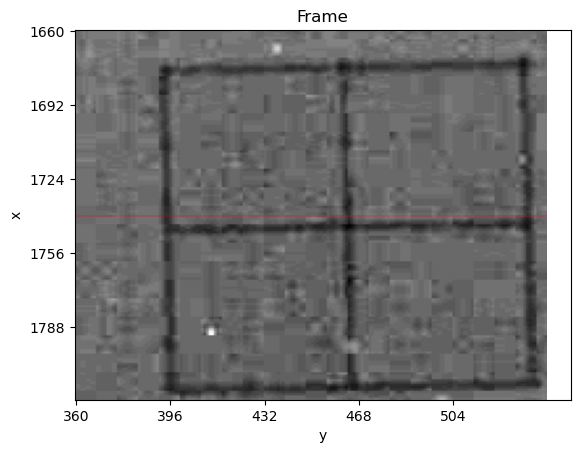

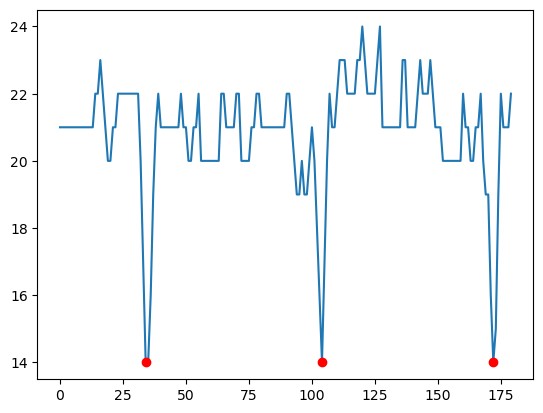

[70 68]


In [44]:
index = 0
frame = video_loader.get_frame(index)
n_px = tools.find_gridsize(frame, x_up=par['x_up'],x_down=par['x_down'],y_left=par['y_left'],y_right=par['y_right'], window_size=par['window_size'])
res = 10/n_px

In [45]:
res

np.float64(0.14492753623188406)

In [ ]:
tools.find_gridsize

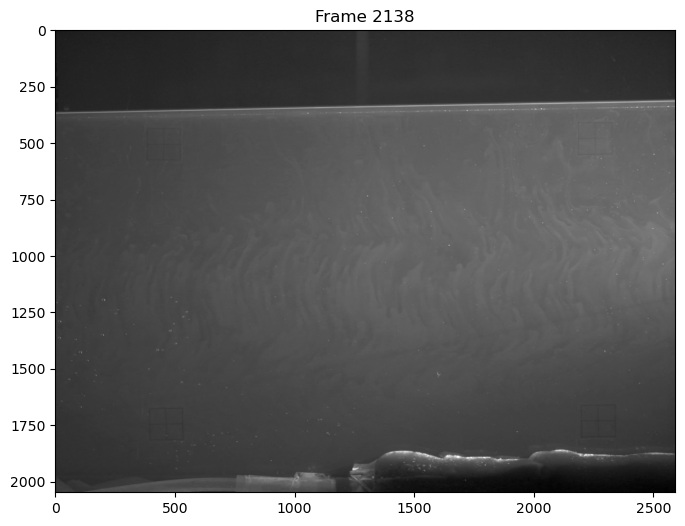

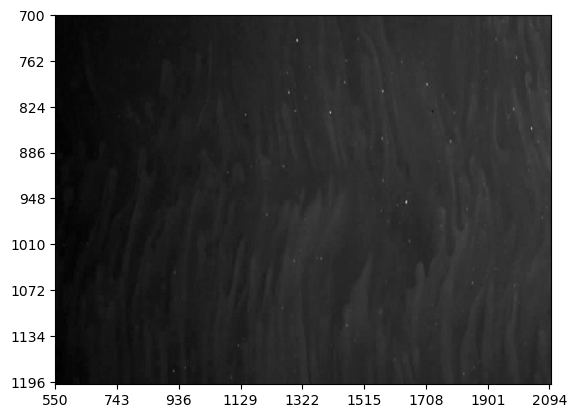

In [48]:
x_up, x_down, y_left, y_right = tools.find_size(video_loader, x_up=par_window['x_up'],x_down=par_window['x_down'],y_left=par_window['y_left'],y_right=par_window['y_right'],color_channel=1)

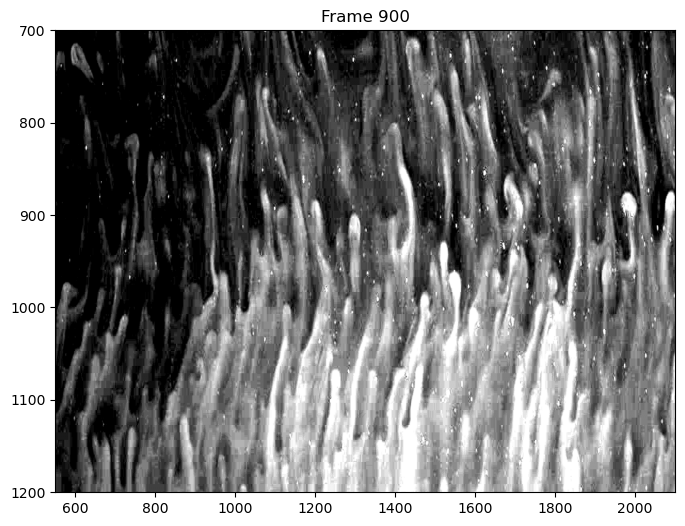

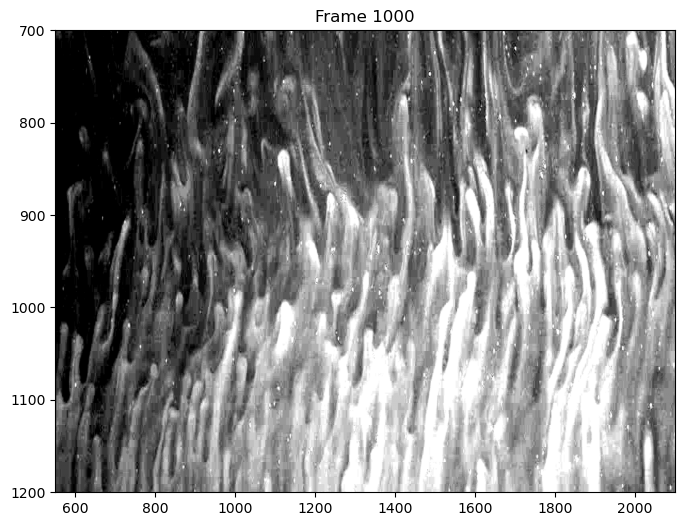

In [83]:
video_loader.display_frame(900, x_up=par_window['x_up'],x_down=par_window['x_down'],y_left=par_window['y_left'],y_right=par_window['y_right'],v_min=50,v_max=70)
video_loader.display_frame(1000, x_up=par_window['x_up'],x_down=par_window['x_down'],y_left=par_window['y_left'],y_right=par_window['y_right'],v_min=50,v_max=70)

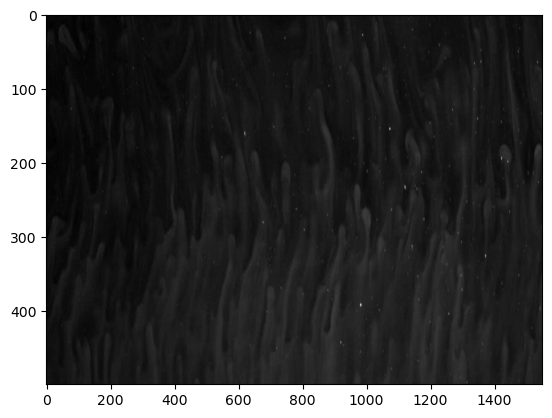

  0%|          | 0/100 [00:00<?, ?it/s]

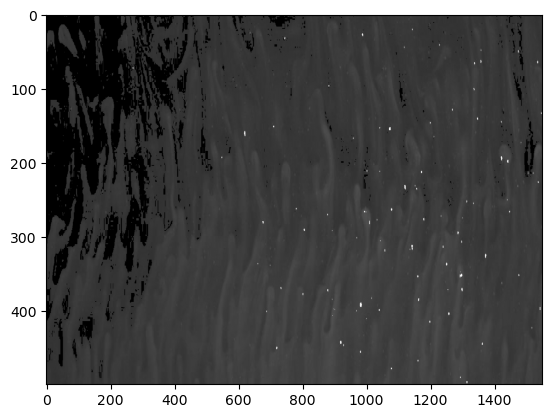

100%|██████████| 100/100 [00:00<00:00, 118.81it/s]


In [84]:
frequencies, magnitudes = tools.fourier_analysis(video_loader,res, x_up=par_window['x_up'],x_down=par_window['x_down'],y_left=par_window['y_left'],y_right=par_window['y_right'],start_frame=900, end_frame=1000,v_min=50,v_max=80)

In [85]:
def fourier_animation(frequencies, magnitudes,baseline_horizontal=0,baseline_vertical=0, average=20):
    frequencies = frequencies.copy()
    magnitudes = magnitudes.copy()
    for key in frequencies.keys():
    #plt.plot(frequencies[key], magnitudes[key], label=key)
        frequencies[key] = np.array([np.mean(frequencies[key][i:i+average],axis=0) for i in range(0, len(frequencies[key]), average)])
        magnitudes[key] = np.array([np.mean(magnitudes[key][i:i+average],axis=0) for i in range(0, len(magnitudes[key]), average)])

    
    precomputed_differences = {
        "horizontal_diff": np.abs(magnitudes["horizontal"] - baseline_horizontal),
        "vertical_diff": np.abs(magnitudes["vertical"] - baseline_vertical),
        "horizontal_freq": frequencies["horizontal"],
        "vertical_freq":  frequencies["vertical"]
    }
    def update(frame_index):
        diff_h = precomputed_differences["horizontal_diff"][frame_index]
        diff_v = precomputed_differences["vertical_diff"][frame_index]
        freq_h = precomputed_differences["horizontal_freq"][frame_index]
        freq_v = precomputed_differences["vertical_freq"][frame_index]
        #print(diff_h, diff_v, freq_h, freq_v)
        # Update scatter plots
        horizontal_scatter.set_offsets(np.c_[freq_h, diff_h])
        vertical_scatter.set_offsets(np.c_[freq_v, diff_v])
        # ax[0].set_title(f"Horizontal Fourier Transform (average of frames {frame_index * average}-{frame_index * average + average})")
        return horizontal_scatter, vertical_scatter

    # Create animations for horizontal and vertical frequencies
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    # Scatter plot placeholders
    def init_func():
        # ax[0].set_xlim(0,1)
        # ax[0].set_ylim(1, 1e8)
        ax[0].set_yscale('symlog', linthresh=0.1)  # Symmetric log scale for differences
        ax[0].set_title("Horizontal Fourier Transform")
        ax[0].set_xlabel("Freq (1/mm)")
        ax[0].set_ylabel("Magnitude")
        ax[0].legend()
        ax[0].grid()

        # ax[1].set_xlim(0, 1)
        # ax[1].set_ylim(1, 1e8)
        ax[1].set_yscale('symlog', linthresh=0.1)  # Symmetric log scale for differences
        ax[1].set_title("Vertical Fourier Transform")
        ax[1].set_xlabel("Freq (1/mm)")
        ax[1].set_ylabel("Magnitude")
        ax[1].legend()
        ax[1].grid()

    horizontal_scatter = ax[0].scatter([], [], label="Horizontal Difference", color="blue", s=1)
    vertical_scatter = ax[1].scatter([], [], label="Vertical Difference", color="red", s=1)
    ax[1].set_xlim(0, 2)
    ax[0].set_xlim(0, 2)
    ax[0].set_ylim(precomputed_differences["horizontal_diff"].min()-1, precomputed_differences["horizontal_diff"].max()+1)
    ax[1].set_ylim(precomputed_differences["vertical_diff"].min()-1, precomputed_differences["vertical_diff"].max()+1)
    ani = FuncAnimation(fig, update, frames=len(precomputed_differences["horizontal_diff"]), init_func=init_func, blit=False, repeat=True)
    #plt.show()
    return ani

In [86]:
frequencies

{'horizontal': array([[ 0.    ,  0.0138,  0.0276, ..., -0.0414, -0.0276, -0.0138],
        [ 0.    ,  0.0138,  0.0276, ..., -0.0414, -0.0276, -0.0138],
        [ 0.    ,  0.0138,  0.0276, ..., -0.0414, -0.0276, -0.0138],
        ...,
        [ 0.    ,  0.0138,  0.0276, ..., -0.0414, -0.0276, -0.0138],
        [ 0.    ,  0.0138,  0.0276, ..., -0.0414, -0.0276, -0.0138],
        [ 0.    ,  0.0138,  0.0276, ..., -0.0414, -0.0276, -0.0138]],
       shape=(100, 500)),
 'vertical': array([[ 0.        ,  0.00445161,  0.00890323, ..., -0.01335484,
         -0.00890323, -0.00445161],
        [ 0.        ,  0.00445161,  0.00890323, ..., -0.01335484,
         -0.00890323, -0.00445161],
        [ 0.        ,  0.00445161,  0.00890323, ..., -0.01335484,
         -0.00890323, -0.00445161],
        ...,
        [ 0.        ,  0.00445161,  0.00890323, ..., -0.01335484,
         -0.00890323, -0.00445161],
        [ 0.        ,  0.00445161,  0.00890323, ..., -0.01335484,
         -0.00890323, -0.00445161

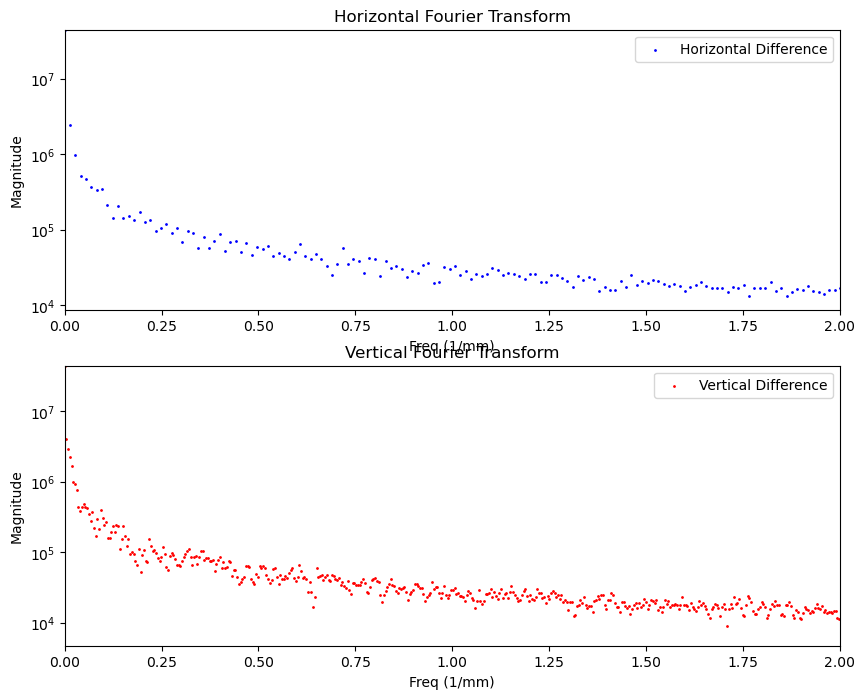

In [87]:
animation = fourier_animation(frequencies, magnitudes,baseline_horizontal=0,baseline_vertical=0, average=10)
HTML(animation.to_jshtml())

In [10]:
'''
frame_indices = np.arange(0,1500,10)  # Example indices of frames to analyze
print("Total frames in video:", video_loader.get_number_of_frames())
pixel_size_mm = res   # Pixel size in mm
frames = []
for index in tqdm.tqdm(frame_indices):
    y = int(1500 - (index - 400)*300/1100)
    if index < 400:
        y = 1500
    frame = video_loader.get_frame(index)[(y-200):(y+200), 500:2200]
    frame[frame > 150] = 150
    frame[frame < 20] = 20
    frames.append(frame)

# Calculate spatial frequencies with scaling
spatial_frequencies, magnitudes = calculate_spatial_frequencies(frames, pixel_size_mm)
'''


'\nframe_indices = np.arange(0,1500,10)  # Example indices of frames to analyze\nprint("Total frames in video:", video_loader.get_number_of_frames())\npixel_size_mm = res   # Pixel size in mm\nframes = []\nfor index in tqdm.tqdm(frame_indices):\n    y = int(1500 - (index - 400)*300/1100)\n    if index < 400:\n        y = 1500\n    frame = video_loader.get_frame(index)[(y-200):(y+200), 500:2200]\n    frame[frame > 150] = 150\n    frame[frame < 20] = 20\n    frames.append(frame)\n\n# Calculate spatial frequencies with scaling\nspatial_frequencies, magnitudes = calculate_spatial_frequencies(frames, pixel_size_mm)\n'

In [23]:
frequencies["vertical"].shape

(26, 1550)

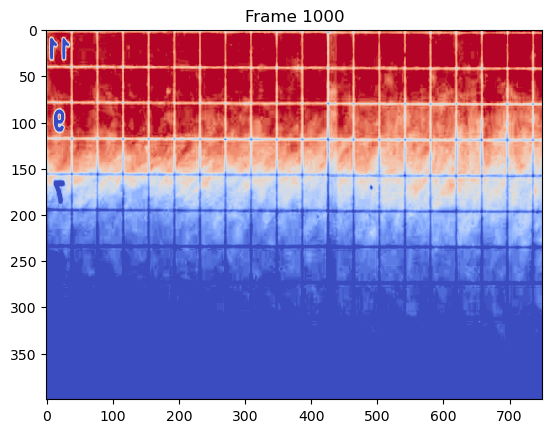

In [302]:
frame_n = 1000
frame = video_loader.get_frame(frame_n,)[1200:1600, 750:1500]
plt.figure()
plt.imshow(frame, cmap='coolwarm', aspect='auto',vmin=80, vmax=125)
plt.title(f"Frame {frame_n}")
plt.show()

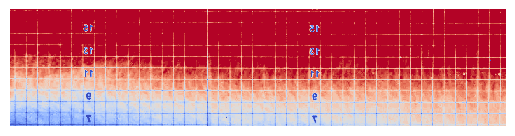

In [107]:
data = frames
N = len(data)
# Create a figure and axis
fig, ax = plt.subplots()
# Initialize the imshow plot with the first frame
im = ax.imshow(data[0], cmap='coolwarm', interpolation='none')
ax.axis("off")  # Turn off axis for clarity

def init():
    """
    Initialize the imshow plot.
    """
    im.set_data(data[0])
    return [im]

def update(frame):
    """
    Update the imshow data for each frame.
    """
    im.set_data(data[frame])
    im.set_clim(vmin=data[frame].min()+20, vmax=data[frame].max()-20)
    return [im]

# Create the animation
ani = FuncAnimation(fig, update, frames=N, init_func=init, blit=True, repeat=True)

ani.save('video.mp4', writer='ffmpeg', fps=5)
plt.show()

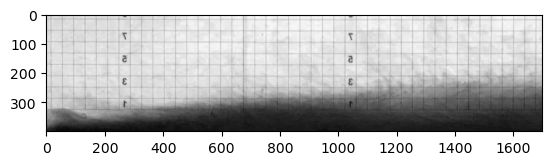

In [97]:
index = 400
y = int(1500 - (index - 400)*300/1100)
frame = video_loader.get_frame(index, color_channel = 2)[(y-200):(y+200), 500:2200]
plt.imshow(frame, cmap="gray")

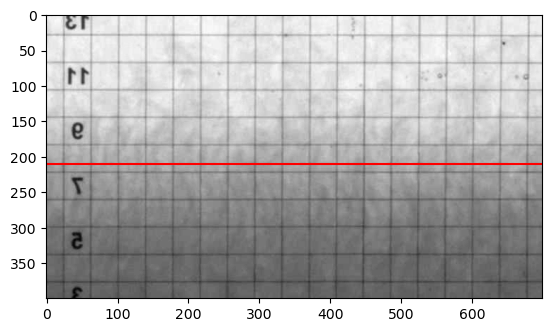

[  1.22597374   1.00230745  -6.6077348  104.69272441]


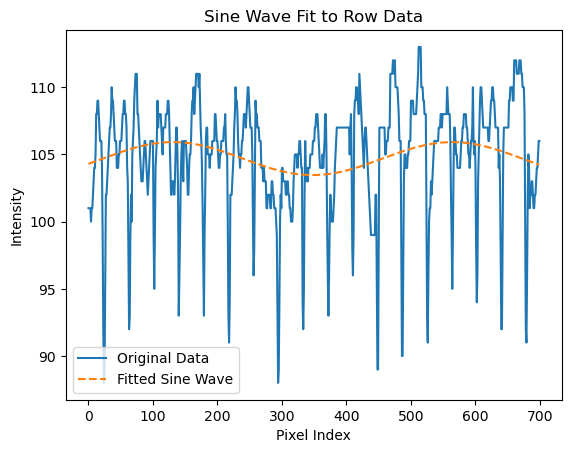

In [303]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset


image = 100
row = 210


image = frames[image][:,1000:1750]


plt.imshow(image, cmap="gray")
plt.axhline(row, color = "red")
plt.show()

x_data = np.arange(len(image[row, :]))
y_data = image[row, :]
# y_data[y_data<105] = 104

# Initial guess for the parameters
p0 = [20, 1, 0, 100]
# Fit the sine function to the data
params, params_covariance = curve_fit(sine_function, x_data, y_data, p0)
print(params)
# Generate the fitted sine wave
fitted_y_data = sine_function(x_data, *params)

# Plot the original data and the fitted sine wave
plt.figure()
plt.plot(x_data, y_data, label='Original Data')
plt.plot(x_data, fitted_y_data, label='Fitted Sine Wave', linestyle='--')
plt.legend()
plt.xlabel('Pixel Index')
plt.ylabel('Intensity')
plt.title('Sine Wave Fit to Row Data')
plt.show()

In [78]:
frames

[array([[70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        ...,
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70]], dtype=uint8),
 array([[70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        ...,
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70]], dtype=uint8),
 array([[70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        ...,
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70]], dtype=uint8),
 array([[70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
        ...,
        [70, 70, 70, ..., 70, 70, 70],
        [70, 70, 70, ..., 70, 70, 70],
      

In [295]:
t = TemperatureProcessor("/Volumes/Untitled/Salt_fingering/Temperature/run_ 29.11.-35.9_36.4.txt")
t.read_data()
t.process_data_to_xarray()
t.dataset

<xarray.Dataset>
Dimensions:         (time: 412, z: 8, z_00: 8, z_01: 8, z_02: 8, z_03: 8)
Coordinates:
  * time            (time) <U8 '12:45:24' '12:45:33' ... '13:11:36' '13:11:37'
  * z_00            (z_00) float64 10.5 12.5 14.5 16.5 18.5 20.5 22.5 24.5
  * z_01            (z_01) float64 9.5 11.5 13.5 15.5 17.5 19.5 21.5 23.5
  * z_02            (z_02) int64 1 3 5 7 9 11 13 15
  * z_03            (z_03) int64 0 2 4 6 8 10 12 14
Dimensions without coordinates: z
Data variables:
    temperature_00  (time, z) float64 20.19 19.94 19.69 19.75 ... nan nan nan
    temperature_01  (time, z) float64 20.44 20.13 19.88 19.56 ... nan nan nan
    temperature_02  (time, z) float64 20.63 20.75 20.38 19.94 ... nan nan nan
    temperature_03  (time, z) float64 20.69 20.13 20.69 ... 19.13 18.63 17.38
Attributes:
    description:  Temperature time series processed into xarray Dataset

In [296]:
time = t.dataset.time
t0 = t.dataset.temperature_00
z0 = t.dataset.z_00
t1 = t.dataset.temperature_01
z1 = t.dataset.z_01
t2 = t.dataset.temperature_02
z2 = t.dataset.z_02
t3 = t.dataset.temperature_03
z3 = t.dataset.z_03
temp = np.concatenate([t0, t1, t2, t3], axis=1)
z = np.concatenate([z0, z1, z2, z3], axis=0)
t_sticks = xr.Dataset(
    data_vars={
        "temperature": (["time", "z"], temp)  # Correctly specify the variable name and dimensions
    },
    coords={
        'time': time.values,  # Ensure time is in a compatible format (like np.array or list)
        'z': z                # z-coordinate values
    },
    attrs={
        'description': 'Temperature time series processed into xarray Dataset'
    }
)

In [297]:
### sort the dataset in z directions
t_sticks = t_sticks.sortby("z")

In [298]:
# Fill NaN values with the temperature at the same z from the last timestep where there was a value
t_sticks['temperature'] = t_sticks['temperature'].ffill(dim='time')


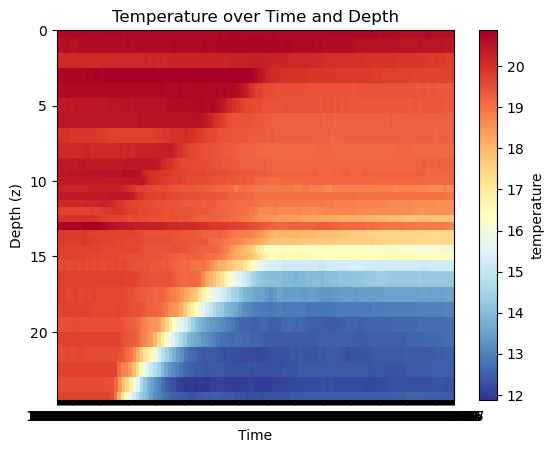

In [299]:
t_sticks.temperature.plot(x='time', y='z', cmap='RdYlBu_r', vmin=t_sticks.temperature.min(), vmax=t_sticks.temperature.max())
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (z)')
plt.title('Temperature over Time and Depth')
plt.savefig('temperature.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
t_sticks.temperature.plot(x='time', y='z', cmap='RdYlBu_r', vmin=13, vmax=t_sticks.temperature.max())
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (z)')
plt.title('Temperature over Time and Depth')
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

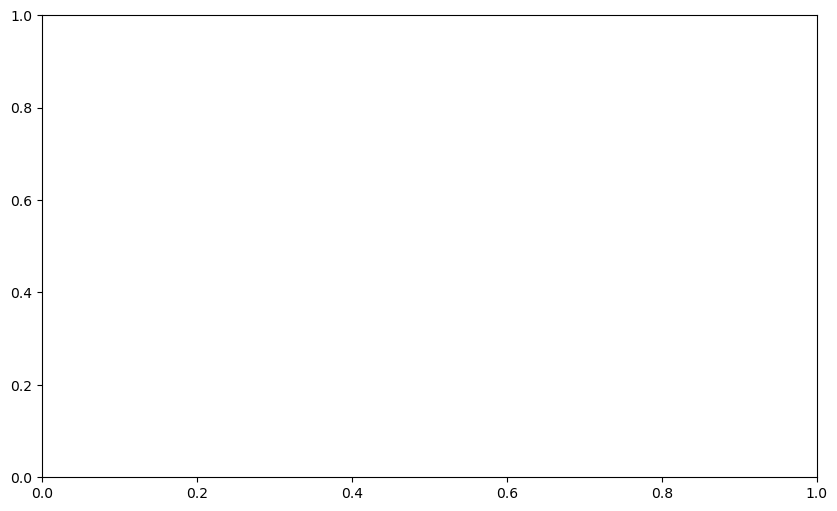

In [243]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the data from the xarray
time = t_sticks.time.values
z = t_sticks.z.values
temperature = t_sticks.temperature.values

# Create a meshgrid for the time and z coordinates
T, Z = np.meshgrid(time, z)

# Create the mesh plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(T, Z, np.array(temperature.T), shading='auto', cmap='viridis')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time')
plt.ylabel('Depth (z)')
plt.title('Temperature over Time and Depth')
plt.gca().invert_yaxis()
plt.show()

In [286]:
xr.to_datetime()

AttributeError: module 'xarray' has no attribute 'to_datetime'

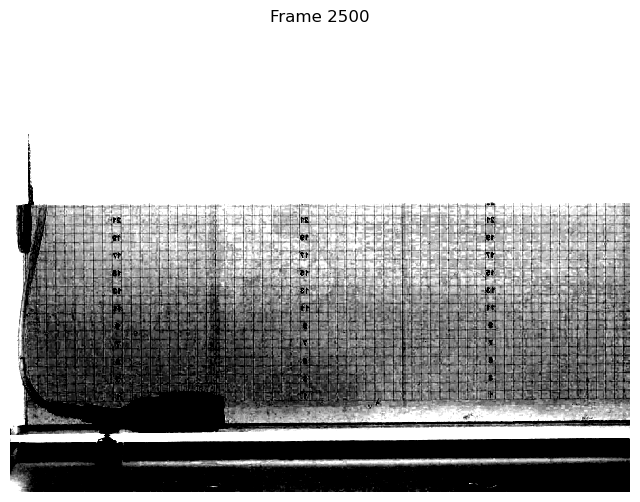

In [264]:
video_loader.display_frame(2500, color_channel=2, v_min=22, v_max=32)

In [259]:
video_loader.get_frame(2500, color_channel=2)

array([[122, 123, 123, ..., 131, 131, 131],
       [122, 123, 123, ..., 131, 131, 131],
       [122, 123, 123, ..., 131, 131, 131],
       ...,
       [ 39,  39,  39, ...,  15,  17,  18],
       [ 41,  40,  40, ...,  15,  17,  18],
       [ 42,  41,  41, ...,  15,  17,  18]], dtype=uint8)

In [319]:
horizontal = np.array([x[0,:] for x in magnitudes])

In [334]:
hor = horizontal.mean(axis=0)[1:]
s = spatial_frequencies[0]["horizontal_freq"][1:]

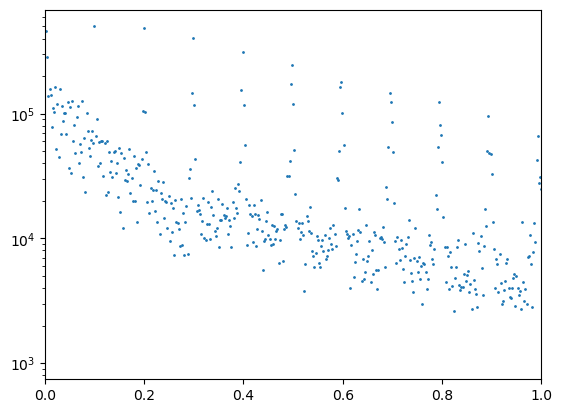

In [344]:
plt.scatter(s,hor, s=1)
plt.plot(np.arange(0,1,0.01), 10**5 - )
plt.xlim(0, 1)
plt.yscale('log')

In [331]:
spatial_frequencies[0]["horizontal_freq"]

array([ 0.        ,  0.00226244,  0.00452489, ..., -0.00678733,
       -0.00452489, -0.00226244])

In [339]:
spatial_frequencies[0]["horizontal_freq"]

array([ 0.        ,  0.00226244,  0.00452489, ..., -0.00678733,
       -0.00452489, -0.00226244])

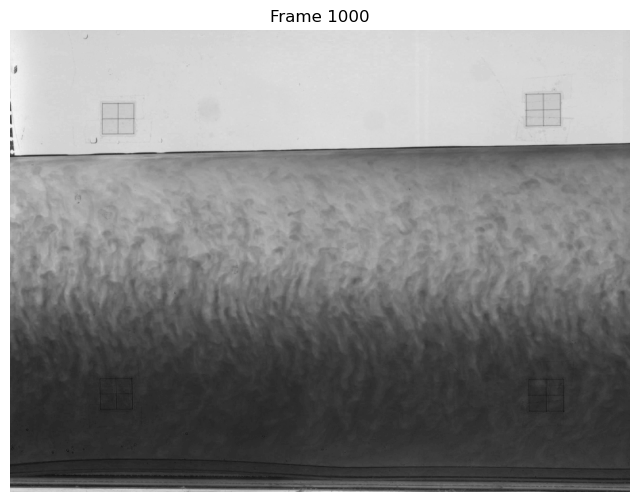

In [10]:
video_loader.display_frame(1000, color_channel=2)